In [2]:
# library imports
import pandas as pd
import sys
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
from collections import OrderedDict

In [3]:
# Reading vaccination data
cwd = './'
vacdat_file_path = os.path.join(cwd,'covid_vaccination_progress', 'country_vaccinations.csv')

vacdat = pd.read_csv(vacdat_file_path)
total_records = vacdat.shape[0]
vacdat.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...


In [4]:
# Obtaining list of all countries in alphabetical order
countries = list(set(vacdat['country']))
countries.sort()


In [5]:
# Removing NaN values
nan_remove = ['total_vaccinations',
            'people_vaccinated',
            'people_fully_vaccinated',
            'daily_vaccinations_raw',
            'daily_vaccinations',
            'people_vaccinated_per_hundred',
            'people_fully_vaccinated_per_hundred',
            'daily_vaccinations_per_million']
for col_name in nan_remove:
    vacdat[col_name].fillna(0, inplace=True)
vacdat['date'] = pd.to_datetime(vacdat['date'])
vacdat.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
1,Albania,ALB,2021-01-11,0.0,0.0,0.0,0.0,64.0,NaN,0.00,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
2,Albania,ALB,2021-01-12,128.0,128.0,0.0,0.0,64.0,0.00,0.00,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
3,Albania,ALB,2021-01-13,188.0,188.0,0.0,60.0,63.0,0.01,0.01,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
4,Albania,ALB,2021-01-14,266.0,266.0,0.0,78.0,66.0,0.01,0.01,0.0,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...


In [6]:
# What are all the vaccine brands being used?
print(set(vacdat['vaccines'].values))

{'Pfizer/BioNTech', 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech', 'Pfizer/BioNTech, Sinopharm/Beijing', 'Oxford/AstraZeneca, Sinovac', 'Oxford/AstraZeneca', 'Oxford/AstraZeneca, Pfizer/BioNTech', 'Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V', 'Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V', 'Sinopharm/Beijing', 'Sinovac', 'Covaxin, Oxford/AstraZeneca', 'Pfizer/BioNTech, Sinovac', 'Oxford/AstraZeneca, Sinopharm/Beijing', 'Sputnik V', 'Moderna, Pfizer/BioNTech', 'Oxford/AstraZeneca, Sputnik V', 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sinopharm/Wuhan, Sputnik V', 'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac'}


In [7]:
# Remapping vaccine-identifying strings to a shorter more readable tag
vac_tags = ['Oxford',
            'Pfizer',
            'Sinopharm-W',
            'Sinopharm-B',
            'Sinovac',
            'Sputnik V',
            'Moderna',
            'Covaxin']
vac_hash = OrderedDict()
vac_hash['Oxford/AstraZeneca'] = 'Oxford'
vac_hash['Pfizer/BioNTech'] = 'Pfizer'
vac_hash['Sinopharm/Wuhan'] = 'Sinopharm-W'
vac_hash['Sinopharm/Beijing'] = 'Sinopharm-B'
vac_hash['Sinovac'] = 'Sinovac'
vac_hash['Sputnik V'] = 'Sputnik V'
vac_hash['Moderna'] = 'Moderna'
vac_hash['Covaxin'] = 'Covaxin'


In [8]:
vac_series = {}
for tag in vac_tags:
    vac_series[tag] = [0]*total_records

In [9]:
# Converting the database's vaccine identifying strings to more readable tags
new_vac_col = []
row_indx = 0
for record in vacdat['vaccines'].values:
    components = record.replace(', ',',').split(",")
    new_components = []
    for sub_component in components:
        if sub_component in vac_hash.keys():
            new_components.append(vac_hash[sub_component])
            vac_series[vac_hash[sub_component]][row_indx] = 1
        else:
            msg = "Warning. vacccine name {} not found in hash".format(sub_component)
            print(msg)
            break
        new_vac_col.append(new_components)
    row_indx+=1

In [10]:
# Creating a dictionary with empty arrays. It will be used to
# store the countries using a given vaccine brand
vac_tag_in_country = {}
for vac_tag in vac_tags:
    vac_tag_in_country[vac_tag] = []

In [11]:
# %%
insert_loc = 13
for j, vac_tag in enumerate(vac_tags):
    vacdat.insert(insert_loc + j, vac_tag, vac_series[vac_tag])
vacdat.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,...,Oxford,Pfizer,Sinopharm-W,Sinopharm-B,Sinovac,Sputnik V,Moderna,Covaxin,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
1,Albania,ALB,2021-01-11,0.0,0.0,0.0,0.0,64.0,NaN,0.00,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
2,Albania,ALB,2021-01-12,128.0,128.0,0.0,0.0,64.0,0.00,0.00,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
3,Albania,ALB,2021-01-13,188.0,188.0,0.0,60.0,63.0,0.01,0.01,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
4,Albania,ALB,2021-01-14,266.0,266.0,0.0,78.0,66.0,0.01,0.01,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...


In [12]:
# Creating a dictionary of  country populations
power_countries = [
    'China',
    'United States',
    'Germany',
    'India',
    'Italy',
    'France',
    'United Kingdom',
    'Brazil',
    'Canada',
    'Russia',
    'Israel']
power_countries_population = OrderedDict()    
power_countries_population['China'] = 1.398E9
power_countries_population['United States'] = 328.2E6
power_countries_population['Germany'] = 83.02E6
power_countries_population['India'] = 1.366E9
power_countries_population['Italy'] = 60.36E6
power_countries_population['France'] = 67.06E6
power_countries_population['United Kingdom'] = 66.65E6
power_countries_population['Brazil'] = 211E6
power_countries_population['Canada'] = 37.59E6
power_countries_population['Russia'] = 144.4E6
power_countries_population['Israel'] = 9.053E6

In [13]:
# This sections generates new analytic data from existing data. The new data will be
# presented and analyzed through graphics and text

total_vaccinations_per_country = OrderedDict()
country_dic = OrderedDict()

country_dic['country'] = []
country_dic['start_date'] = []
country_dic['end_date'] = []
country_dic['avg_vac_speed'] = []
country_dic['total_vacs'] = []
country_dic['reported_days'] = []

country_daily_vacs = {'country': [], 'country_daily_vacs': []}
def delta_days(end_date, start_date):
    time_frame = end_date - start_date
    time_frame = time_frame.astype('timedelta64[D]')
    return time_frame / np.timedelta64(1, 'D')
power_country_indx = []
j = 0    
for country in countries:
    if country in power_countries:
        power_country_indx.append(j)
    sub_frame = vacdat[vacdat['country']==country]
    country_dic['country'].append(country)
    country_dic['total_vacs'].append(sub_frame['total_vaccinations'].values[-1])
    country_dic['start_date'].append(sub_frame['date'].values[0])
    country_dic['end_date'].append(sub_frame['date'].values[-1])
    country_dic['reported_days'].append(delta_days(sub_frame['date'].values[-1], sub_frame['date'].values[0]))
    country_dic['avg_vac_speed'].append(country_dic['total_vacs'][-1]/country_dic['reported_days'][-1])
    country_daily_vacs['country'].append(country)
    country_daily_vacs['country_daily_vacs'].append(sub_frame['daily_vaccinations'].values[:])
    for vac_tag in vac_tags:
        if any(sub_frame[vac_tag].values):
            vac_tag_in_country[vac_tag].append(country)
    j+=1
country_df = pd.DataFrame(country_dic)
    

<ipython-input-13-5612b90d92f7>:30: RuntimeWarning: divide by zero encountered in double_scalars
  country_dic['avg_vac_speed'].append(country_dic['total_vacs'][-1]/country_dic['reported_days'][-1])


In [14]:
# Displaying information about vaccine brand reach
for tag in vac_tags:
    print("The vaccine '{0}' is being used in {1} countries".format(tag, len(vac_tag_in_country[tag])))

The vaccine 'Oxford' is being used in 45 countries
The vaccine 'Pfizer' is being used in 65 countries
The vaccine 'Sinopharm-W' is being used in 2 countries
The vaccine 'Sinopharm-B' is being used in 10 countries
The vaccine 'Sinovac' is being used in 6 countries
The vaccine 'Sputnik V' is being used in 9 countries
The vaccine 'Moderna' is being used in 27 countries
The vaccine 'Covaxin' is being used in 1 countries


In [15]:
# Creating a subset of the dataframe. Includes a limited number of countries, mostly industrialized.
power_country_df = country_df.iloc[power_country_indx, :]
print(power_country_df)
power_country_df.describe()

           country start_date   end_date  avg_vac_speed  total_vacs  \
12          Brazil 2021-01-16 2021-02-15  176465.966667   5293979.0   
15          Canada 2020-12-19 2021-02-15   21695.862069   1258360.0   
18           China 2020-12-15 2021-02-09  723571.428571  40520000.0   
30          France 2020-12-27 2021-02-14   59111.673469   2896472.0   
31         Germany 2020-12-27 2021-02-14   84619.346939   4146348.0   
38           India 2021-01-15 2021-02-15  281316.838710   8720822.0   
43          Israel 2020-12-19 2021-02-15  113789.637931   6599799.0   
44           Italy 2020-12-27 2021-02-15   60890.700000   3044535.0   
71          Russia 2020-12-15 2021-02-10   68421.052632   3900000.0   
87  United Kingdom 2020-12-13 2021-02-14  251425.095238  15839781.0   
88   United States 2020-12-20 2021-02-14  944363.500000  52884356.0   

    reported_days  
12           30.0  
15           58.0  
18           56.0  
30           49.0  
31           49.0  
38           31.0  
43     

,avg_vac_speed,total_vacs,reported_days
count,11.000000,1.100000e+01,11.000000
mean,253242.827475,1.319131e+07,50.636364
std,302635.642220,1.724728e+07,10.846868
min,21695.862069,1.258360e+06,30.000000
25%,64655.876316,3.472268e+06,49.000000
50%,113789.637931,5.293979e+06,56.000000
75%,266370.966974,1.228030e+07,57.500000
max,944363.500000,5.288436e+07,63.000000


In [16]:
# Mapping Country DF with metadata about the countries population.
ordered_population = [int(power_countries_population[country]) for country in power_country_df['country'].values]
power_country_df['population'] = ordered_population
# Nomralizing vaccination rate to the countries population
power_country_df['normalized_vac_speed'] = power_country_df['avg_vac_speed']/power_country_df['population']
power_country_df = power_country_df.sort_values(by='avg_vac_speed', ascending=False)
print(power_country_df)

           country start_date   end_date  avg_vac_speed  total_vacs  \
88   United States 2020-12-20 2021-02-14  944363.500000  52884356.0   
18           China 2020-12-15 2021-02-09  723571.428571  40520000.0   
38           India 2021-01-15 2021-02-15  281316.838710   8720822.0   
87  United Kingdom 2020-12-13 2021-02-14  251425.095238  15839781.0   
12          Brazil 2021-01-16 2021-02-15  176465.966667   5293979.0   
43          Israel 2020-12-19 2021-02-15  113789.637931   6599799.0   
31         Germany 2020-12-27 2021-02-14   84619.346939   4146348.0   
71          Russia 2020-12-15 2021-02-10   68421.052632   3900000.0   
44           Italy 2020-12-27 2021-02-15   60890.700000   3044535.0   
30          France 2020-12-27 2021-02-14   59111.673469   2896472.0   
15          Canada 2020-12-19 2021-02-15   21695.862069   1258360.0   

    reported_days  population  normalized_vac_speed  
88           56.0   328200000              0.002877  
18           56.0  1398000000          

<ipython-input-16-9df8fa84fb43>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_country_df['population'] = ordered_population
<ipython-input-16-9df8fa84fb43>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_country_df['normalized_vac_speed'] = power_country_df['avg_vac_speed']/power_country_df['population']


In [17]:
# Defining a Class to Make horizontal bar graphs
class BarMaker:
    def __init__(self, country_list, title, x_step=12, width=0.35):
        self.fig, self.ax = plt.subplots()
        self.fig.set_size_inches((6, 4))
        self.ax.xaxis.grid(True, linestyle='--', which='major',
                        color='grey', alpha=.8)
        self.horizontal_grid_steps = x_step
        self.fig.tight_layout()
        self.fig.set_dpi(200)
        self.ax.invert_yaxis()
        self.country_list = country_list
        self.ypos = np.arange(len(country_list))
        self.width = width
        self.ax.set_title(title)

    def set_y(self, bar_values, legend=[None]):
        if len(bar_values) == 1:
            self.ax.barh(self.ypos , bar_values[0], align='center', label=legend[0])
        else:
            self.ax.barh(self.ypos - self.width/2, bar_values[0], self.width, align='center', label=legend[0])
            self.ax.barh(self.ypos + self.width/2, bar_values[1], self.width, align='center', label=legend[1])            
        self.ax.set_yticks(self.ypos)
        self.ax.set_yticklabels(self.country_list)

    def set_x(self, max_x, str_normalizer, label):
        xaxis_ticks_num = np.linspace(0, max_x, self.horizontal_grid_steps)
        xaxis_ticks_str = [ "{:.1e}".format(number*str_normalizer) for number in xaxis_ticks_num]
        self.ax.set_xticks(xaxis_ticks_num)
        self.ax.set_xticklabels(xaxis_ticks_str, fontsize=6)
        self.ax.set_xlabel(label)
        self.ax.legend()

    def show(self):
        plt.show()

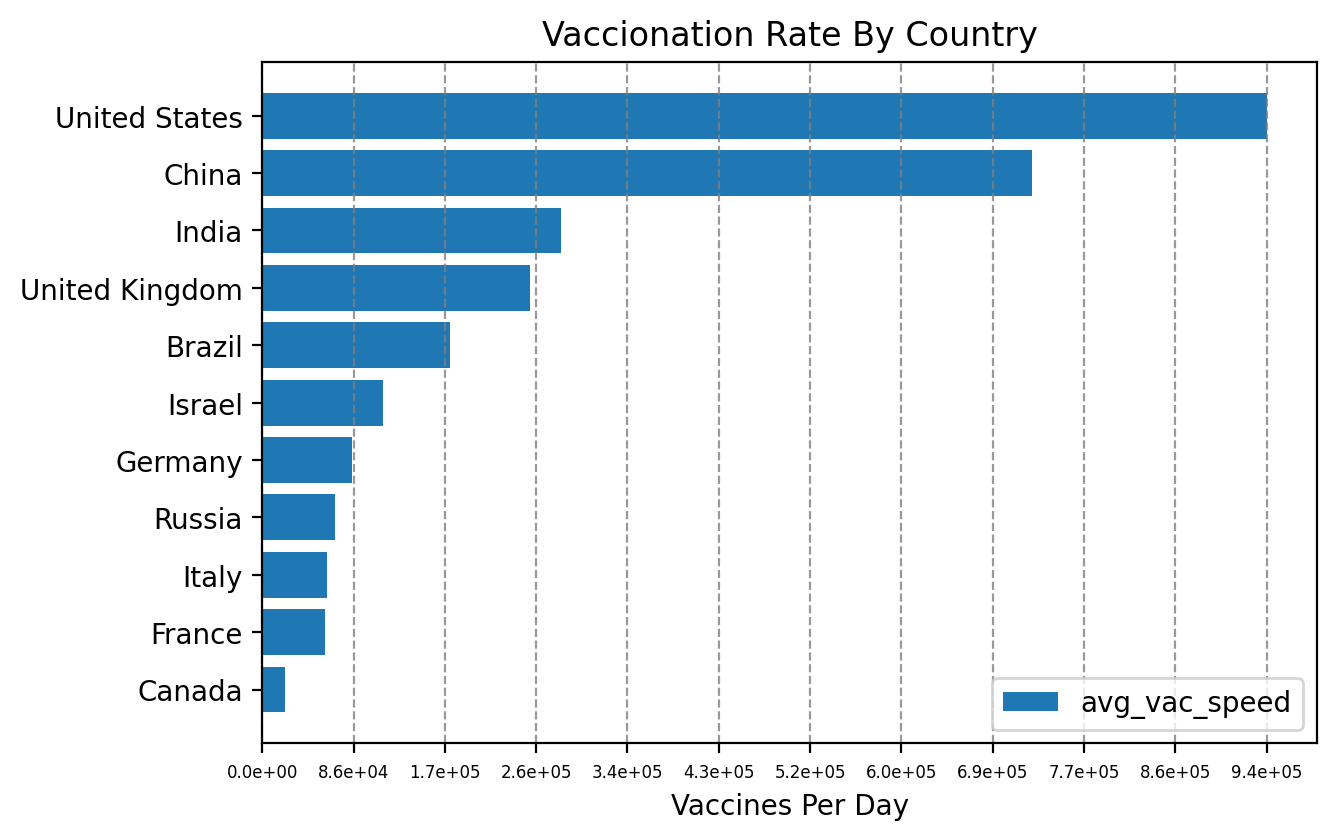

In [18]:
# Vaccines Per Day on Industrialized Countries
power_country_df = power_country_df.sort_values(by='avg_vac_speed', ascending=False)
bar_maker = BarMaker(power_country_df['country'].values, 'Vaccionation Rate By Country')
bar_maker.set_y([power_country_df['avg_vac_speed'].values], legend=['avg_vac_speed'])
bar_maker.set_x(power_country_df['avg_vac_speed'].max(), 1, 'Vaccines Per Day')
bar_maker.show()

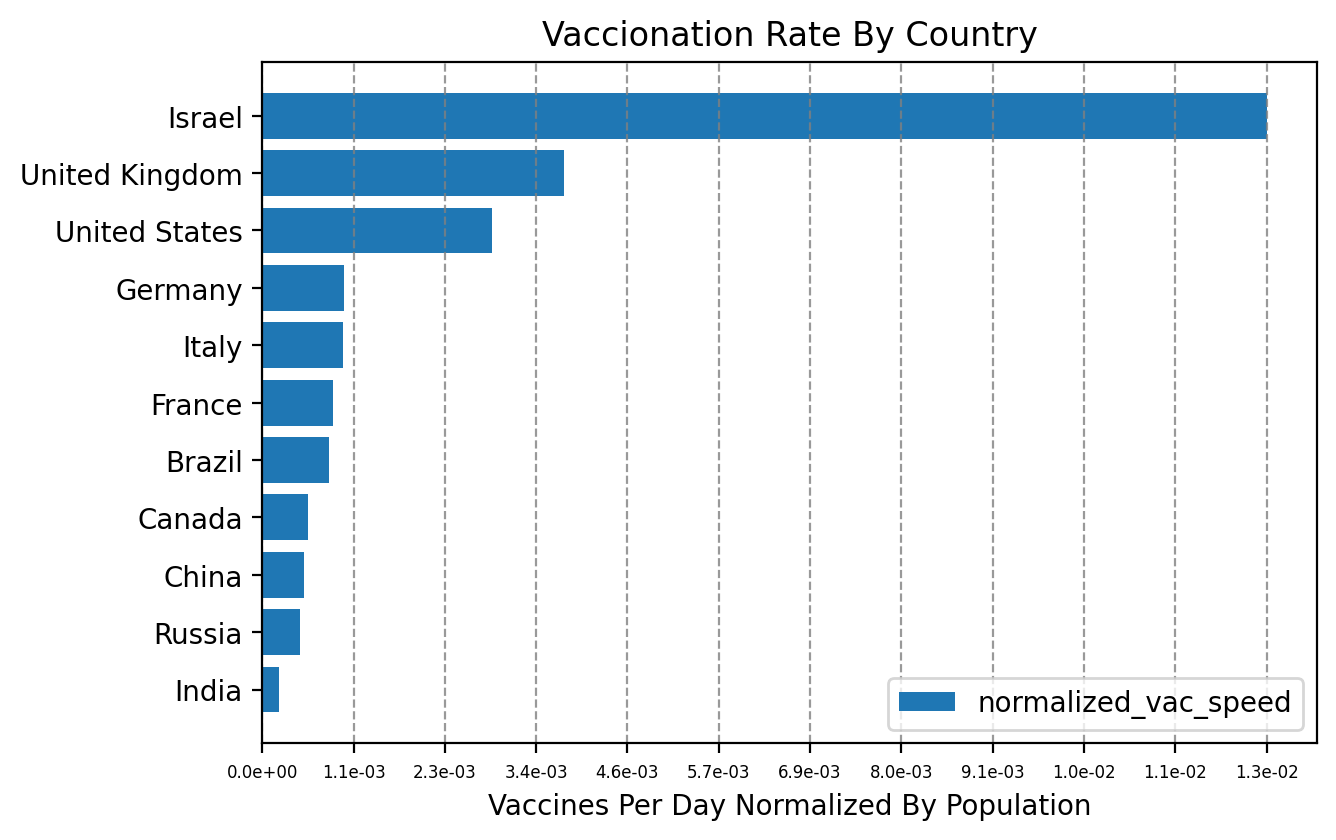

In [19]:
# Vaccines Per Day on Industrialized Countries Normalized by Population
power_country_df = power_country_df.sort_values(by='normalized_vac_speed', ascending=False)
bar_maker = BarMaker(power_country_df['country'].values, 'Vaccionation Rate By Country')
bar_maker.set_y([power_country_df['normalized_vac_speed'].values], legend=['normalized_vac_speed'])
bar_maker.set_x(power_country_df['normalized_vac_speed'].max(), 1, 'Vaccines Per Day Normalized By Population')


In [20]:
# Reading infections per day data
infdat_file_path = os.path.join(cwd,'covid_daily_confirm','worldometer_coronavirus_daily_data.csv')
infdat = pd.read_csv(infdat_file_path)
inf_total_records = vacdat.shape[0]
infdat.head()

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,2020-2-15,Afghanistan,0.0,NaN,0.0,0.0,NaN
1,2020-2-16,Afghanistan,0.0,NaN,0.0,0.0,NaN
2,2020-2-17,Afghanistan,0.0,NaN,0.0,0.0,NaN
3,2020-2-18,Afghanistan,0.0,NaN,0.0,0.0,NaN
4,2020-2-19,Afghanistan,0.0,NaN,0.0,0.0,NaN


In [21]:
# Replacining country tags so they match previous dataset
infdat['country'] = infdat['country'].replace(['UK', 'USA'], ['United Kingdom','United States'])

In [22]:
# This sections generates new analytic data from existing data. The new data will be
# presented and analyzed through graphics and text. This analysis only takes place for the subset
# previously selected datasets. Note that this subset is further contrained by date
infdat['date'] = pd.to_datetime(infdat['date'])
infdat.head()
country_inf_dic =     {'country': [],
    'start_date': [],
    'end_date': [],
    'avg_inf_speed': [],
    'total_inf': [],
    'reported_days': [],
    }
country_daily_inf = {
    'country': [],
    'daily_new_cases': [],
    'active_cases': []}    
power_country_indx = []
j = 0
countries = list(set(infdat['country'].values))
countries.sort()

for country in countries:
    if country in power_countries:
        power_country_indx.append(j)
        sub_frame = infdat[infdat['country']==country]
        sub_frame = sub_frame[sub_frame['date'] > power_country_df['start_date'].min()]
        country_inf_dic['country'].append(country)
        country_inf_dic['total_inf'].append(sub_frame['cumulative_total_cases'].values[-1])
        country_inf_dic['start_date'].append(sub_frame['date'].values[0])
        country_inf_dic['end_date'].append(sub_frame['date'].values[-1])
        country_inf_dic['reported_days'].append(delta_days(sub_frame['date'].values[-1], sub_frame['date'].values[0]))
        country_inf_dic['avg_inf_speed'].append(country_inf_dic['total_inf'][-1]/country_inf_dic['reported_days'][-1])
        country_daily_inf['country'].append(country)
        country_daily_inf['daily_new_cases'].append(sub_frame['daily_new_cases'].values[:])
        country_daily_inf['active_cases'].append(sub_frame['active_cases'].values[:])

        j+=1

In [23]:
# Adding population data to the dataframe
country_inf_df = pd.DataFrame(country_inf_dic)
ordered_population = [int(power_countries_population[country]) for country in country_inf_df['country'].values]
country_inf_df['population'] = ordered_population

No handles with labels found to put in legend.


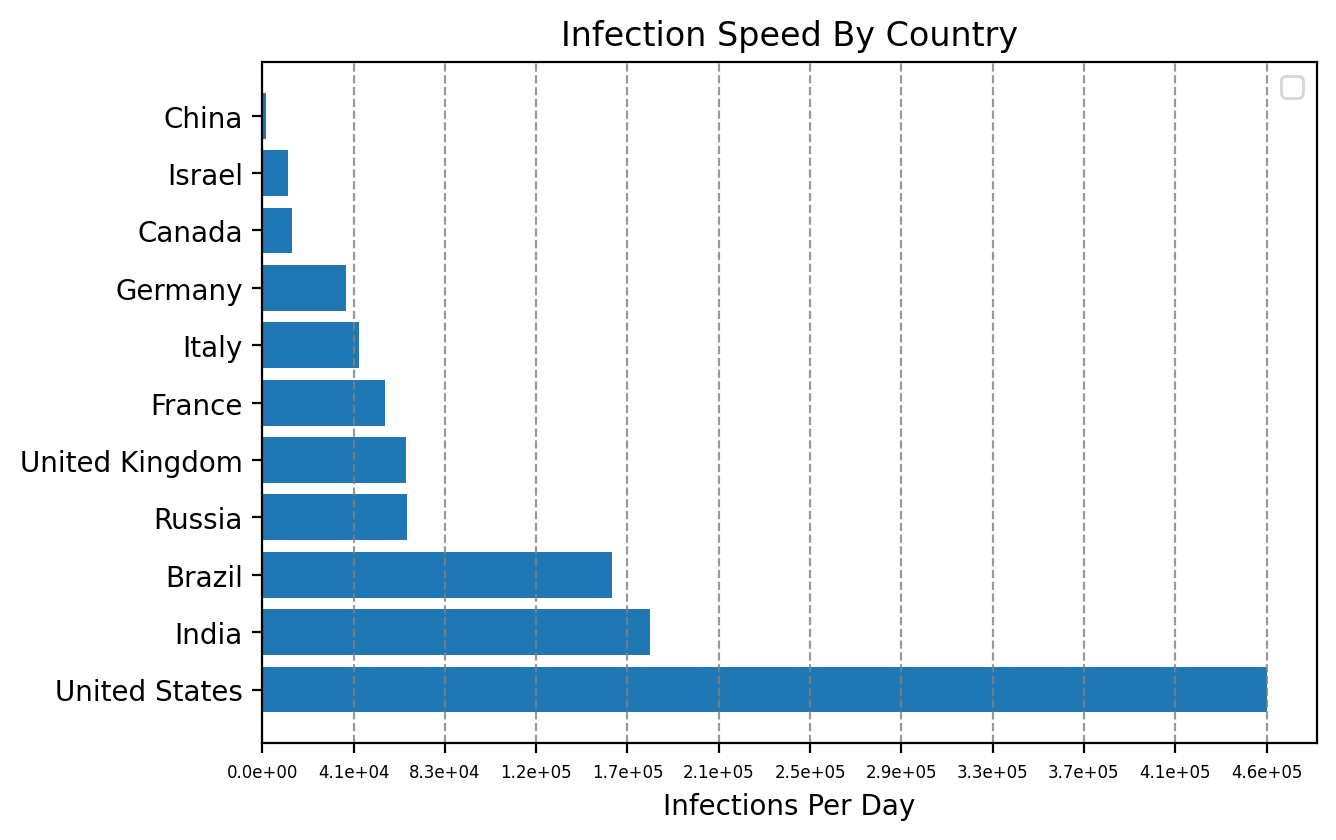

In [24]:
# plotting graph of normalized infection speed normalized by population
country_inf_df = country_inf_df.sort_values(by='avg_inf_speed', ascending=True)
bar_maker = BarMaker(country_inf_df['country'].values, 'Infection Speed By Country')
bar_maker.set_y([country_inf_df['avg_inf_speed'].values])
bar_maker.set_x(country_inf_df['avg_inf_speed'].max(), 1, 'Infections Per Day')
bar_maker.show()

In [25]:
# Adding infection rate normalized by population
country_inf_df['normalized_inf_speed'] = country_inf_df['avg_inf_speed']/country_inf_df['population']


No handles with labels found to put in legend.


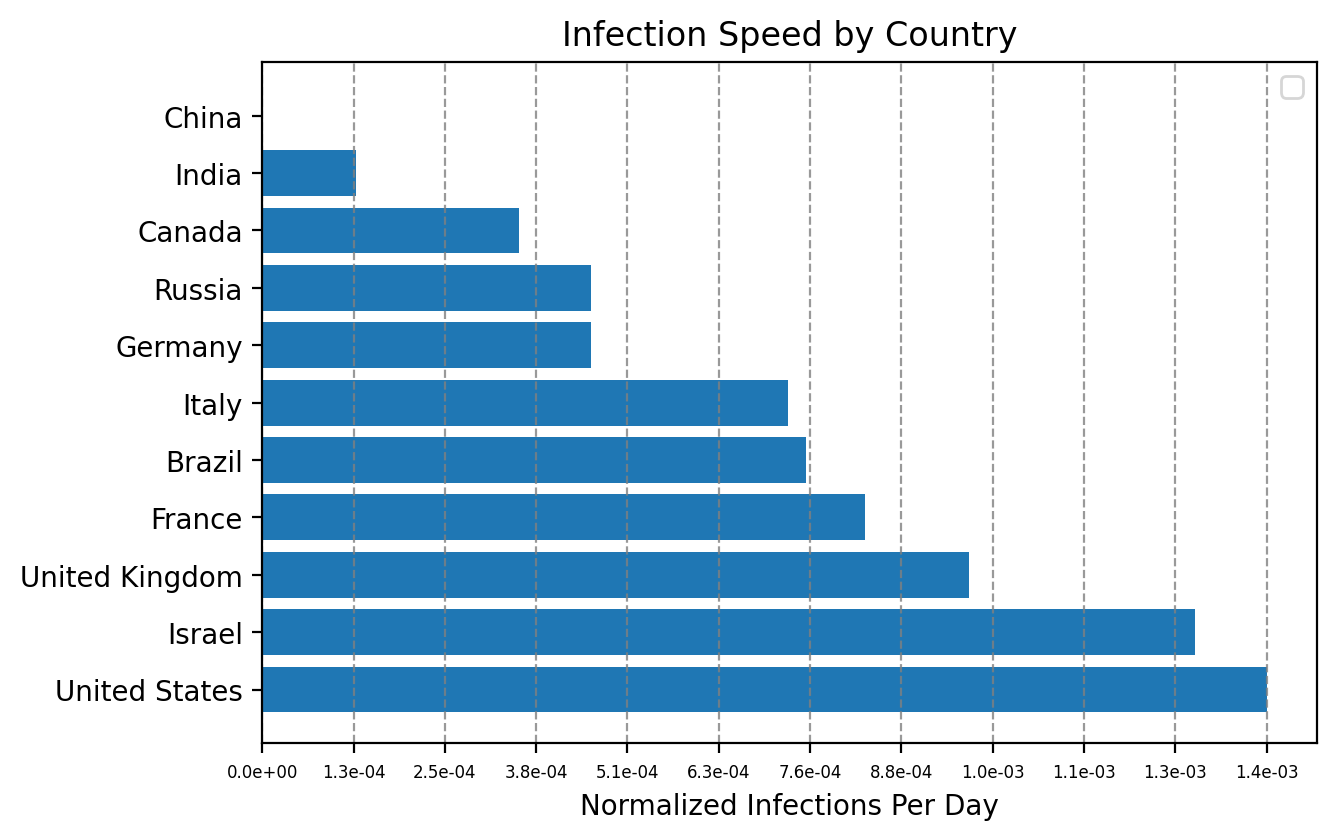

In [26]:
# plotting graph of normalized infection speed normalized by population
country_inf_df = country_inf_df.sort_values(by='normalized_inf_speed', ascending=True)
bar_maker = BarMaker(country_inf_df['country'].values, 'Infection Speed by Country')
bar_maker.set_y([country_inf_df['normalized_inf_speed'].values])
bar_maker.set_x(country_inf_df['normalized_inf_speed'].max(), 1, 'Normalized Infections Per Day')
bar_maker.show()

In [29]:
# Creating a dataset that combines countries, normalized infection
# rate and normalized vaccination speed
country_inf_df = country_inf_df.sort_values(by='country', ascending=False)
power_country_df = power_country_df.sort_values(by='country', ascending=False)

vacs_inf = OrderedDict()
vacs_inf['country'] = []
vacs_inf['normalized_inf_speed'] = []
vacs_inf['normalized_vac_speed'] = []
for country in power_country_df['country'].values:
    vacs_inf['country'].append(country)
    nis = country_inf_df.loc[country_inf_df['country']==country, 'normalized_inf_speed']
    vacs_inf['normalized_inf_speed'].append(nis.values[0])
    nvs = power_country_df.loc[power_country_df['country']==country, 'normalized_vac_speed']
    vacs_inf['normalized_vac_speed'].append(nvs.values[0])
vacs_inf_df = pd.DataFrame(vacs_inf)    

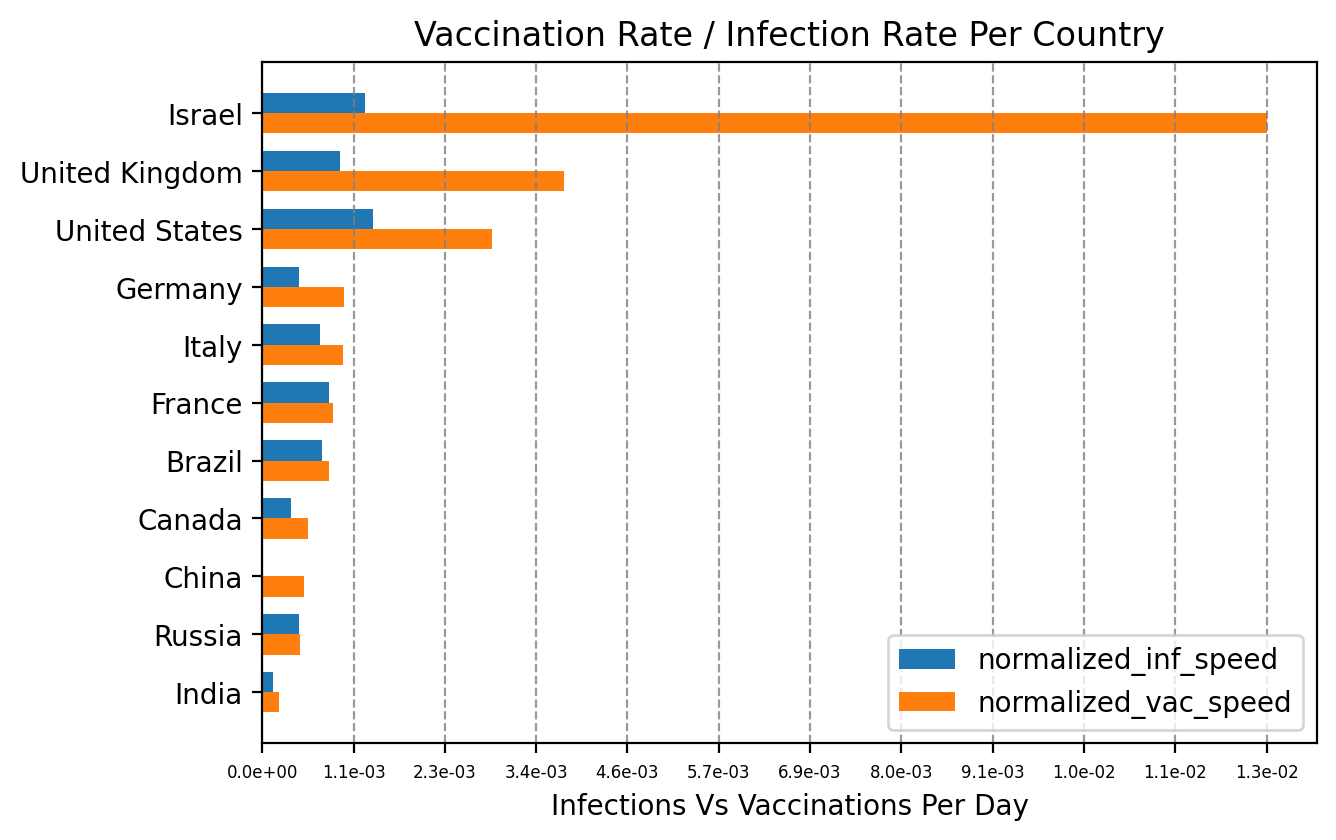

In [30]:
# Plotting infection rate and vaccination rate against the same axis
vacs_inf_df = vacs_inf_df.sort_values(by='normalized_vac_speed', ascending=False)
max_tick = vacs_inf_df['normalized_inf_speed'].max()
if vacs_inf_df['normalized_vac_speed'].max() > max_tick:
    max_tick = vacs_inf_df['normalized_vac_speed'].max()

bars = [vacs_inf_df['normalized_inf_speed'].values, vacs_inf_df['normalized_vac_speed'].values]
legends = ['normalized_inf_speed', 'normalized_vac_speed']
    
bar_maker = BarMaker(vacs_inf_df['country'].values, 'Vaccination Rate / Infection Rate Per Country')
bar_maker.set_y(bars, legend=legends)
bar_maker.set_x(max_tick, 1, 'Infections Vs Vaccinations Per Day')
bar_maker.show()